# Insertion analyses

This Jupyter notebook reproduces various panels from Figure 3, which explores the insertions and common insertion sites (CISs) in the WapCre;Cdh1F/F;SB mouse tumors. As we are specifically interested in ILC, we perform the insertion analysis on a subset of 99 tumors (of the original 123), which were all determined to have an ILC compartment by the morphology analysis. 

The actual insertions are identified using PyIM, a Python package that we created to help in the identification and annotation of insertions/CIS from targeted DNA-sequencing data. As this analysis involves a few computationally expensive steps, the different steps of the PyIM pipeline are run seperately from this notebook using a Snakemake workflow.

PyIM is freely available on GitHub: https://github.com/jrderuiter/pyim

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nbsupport import insertions as nb_ins

sns.set_style('white')

## Insertion statistics

To get a feel for the insertion dataset, we plot a number of statistics describing the distributions of insertion depth/clonality and the number of insertions per sample. We do this both for the full set of insertions and for the subset of insertions that belong to common insertion sites. The latter of these two datasets will be used in subsequent analyses, as we are mainly interested in characterizing the CISs from the screen.

### All insertions

Here, we first load the entire insertion dataset and plot the described statistics. Notice that we convert the 'sample' column in the insertions dataframe to a categorical column, which includes all samples as possible values. This will be important in later analyses of the CIS insertion dataset, as not all samples contain a CIS insertion and we want to avoid dropping these samples from the plots/analyses.

Number of insertions: 3230
Median insertions per sample: 29.0


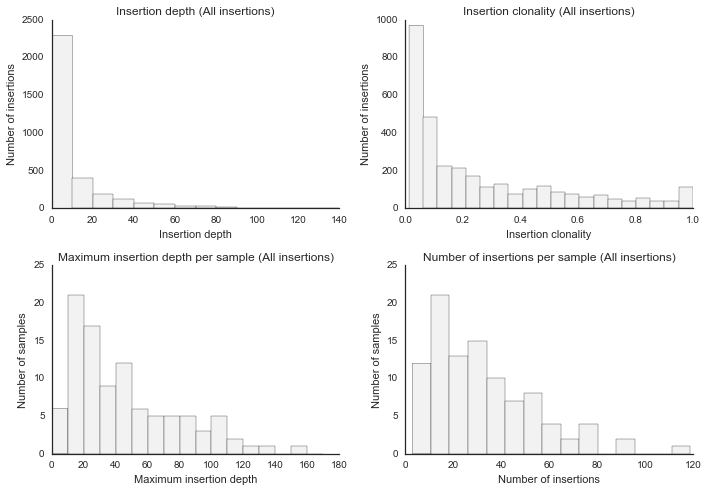

In [2]:
def _read_insertions(file_path, samples=None):
    """Helper function for reading insertions."""
    
    insertions = (pd.read_csv(file_path, sep='\t')
                    .pipe(nb_ins.annotate_with_clonality))
    
    if samples is None:
        samples = insertions['sample'].nunique()
        
    insertions['sample'] = pd.Categorical(
        insertions['sample'], categories=samples)

    return insertions


# Read sample overview and insertions.
samples = (pd.read_csv('../data/raw/sb/samples.txt', sep='\t')
             .query('include_shearsplink == True'))

insertions = _read_insertions('../data/processed/sb/shear_splink/subset/all/'
                              'insertions.txt', samples=samples['sample'])

# Print some basic statistics.
print('Number of insertions: {}'.format(insertions['id'].nunique()))
print('Median insertions per sample: {}'.format(
        insertions.groupby('sample')['id'].nunique().median()))

# Plot stats.
fig, _ = nb_ins.plot_insertion_stats(
    insertions, suffix=' (All insertions)',
    fig_kws={'figsize': (10, 7)}, color=(0.95, 0.95, 0.95))

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, _ = nb_ins.plot_insertion_stats(
        insertions, fig_kws=dict(figsize=(6, 4)),
        color=(0.95, 0.95, 0.95), suffix=' (All insertions)')

fig.savefig('../reports/supplemental/figures/fig_s4_ins_stats.pdf', bbox_inches='tight')
plt.close(fig)

From these plots, we see that the majority of the insertions has a relatively low clonality/depth. This is not unexpected, as these insertions are likely to reflect more subclonal insertions in the tumors. On average, we see a decent depth of 20-30 reads for the strongest insertion in each tumor. Finally, from the last histogram we can see that tumors have an average of ~29 insertions.

### CIS insertions

Next, we perform the same analysis for CIS insertions. 

Number of insertions: 518
Number of CIS: 58
Insertions per sample: 5.0
Number of genes: 30


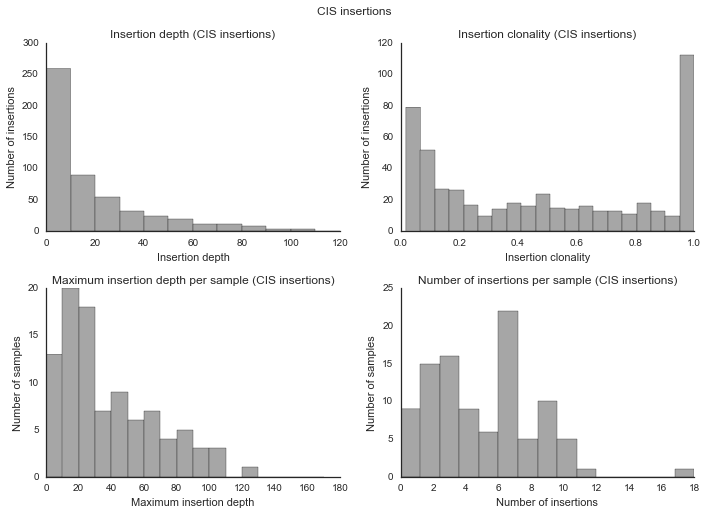

In [3]:
# Read insertions and cis sites.
cis_insertions = _read_insertions('../data/processed/sb/shear_splink/subset/all/'
                                  'insertions.cis.rbm.txt', samples=samples['sample'])

cis_sites = pd.read_csv('../data/processed/sb/shear_splink/subset/all/'
                        'insertions.cis.sites.txt', sep='\t')

# Print some basic statistics.
print('Number of insertions: {}'.format(cis_insertions['id'].nunique()))
print('Number of CIS: {}'.format(cis_sites.shape[0]))
print('Insertions per sample: {}'.format(
        cis_insertions.groupby('sample')['id'].nunique().median()))
print('Number of genes: {}'.format(cis_insertions['gene_name'].nunique()))

# Plot some basis stats.
fig, _ = nb_ins.plot_insertion_stats(
    cis_insertions, fig_kws={'figsize': (10, 7)}, 
    suffix=' (CIS insertions)', color=(0.65, 0.65, 0.65))
fig.suptitle('CIS insertions', fontsize=12, y=1.02);

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, _ = nb_ins.plot_insertion_stats(
        cis_insertions, fig_kws=dict(figsize=(6, 4)), 
        suffix=' (CIS insertions)', color=(0.65, 0.65, 0.65))

fig.savefig('../reports/supplemental/figures/fig_s4_cis_stats.pdf', bbox_inches='tight')
plt.close(fig)

This shows similar results for the depth/clonality distributions, although CIS insertions are more strongly biased towards a high clonality of ~1. Interestingly, tumors still have an average of ~5 CIS insertions, indicating that we can expect tumors to have insertions in multiple candidate genes.

## Candidate overview

To visualize our candidate genes, together with the distribution of their insertions across samples, we plot the insertions as a 2D heatmap of genes-by-samples. The values of this heatmap indicate the clonality of the strongest insertion of the corresponding gene in the given sample.

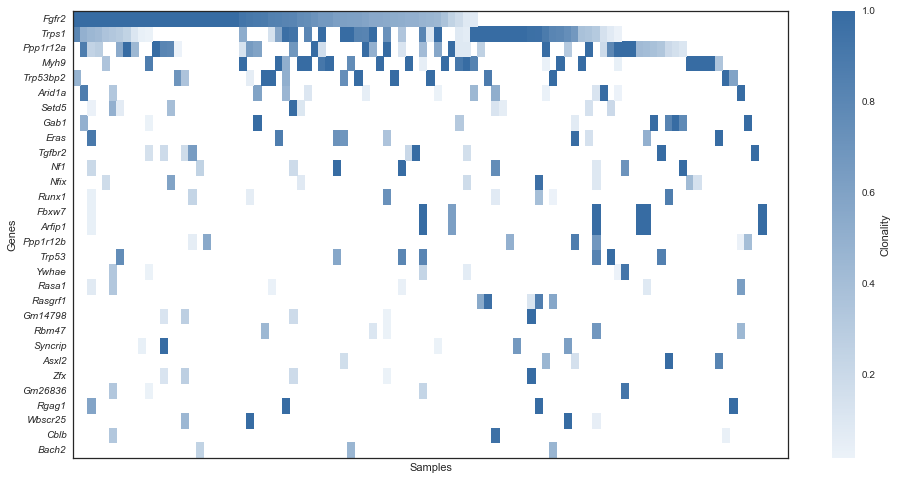

In [4]:
from nbsupport import insertions as nb_ins

fig, ax = plt.subplots(figsize=(16, 8))
nb_ins.plot_insertion_matrix(cis_insertions, ax=ax)

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(9.6, 4))
    nb_ins.plot_insertion_matrix(cis_insertions, ax=ax) 
    fig.savefig('../reports/figures/fig_3_overview.pdf', bbox_inches='tight')
    plt.close()

This shows that a relatively small number of genes (the top 4-5) span the largest set of samples, with *Fgfr2* and *Trps1* affecting approximately half of the samples. Additionally, we see a high degree of co-occurrence between *Fbxw7* and *Arfip1*, which is due to their shared genomic locus.

Another way of visualizing this data, is to make a scatterplot of the number of samples and the mean clonality of each gene. This is a useful plot for prioritizing the different CIS genes, as it highlights insertions that are frequently recurrent and have a high average clonality.

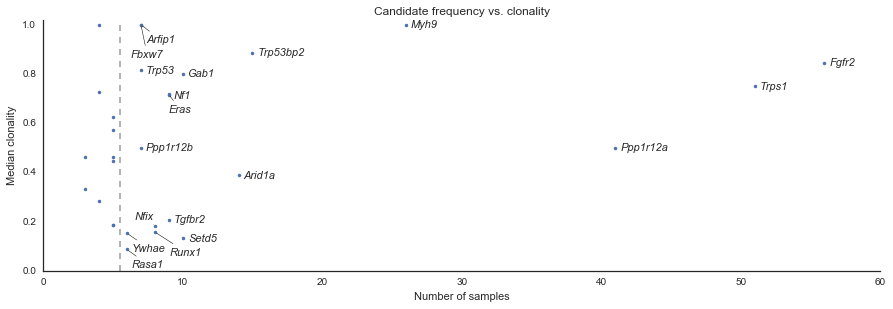

In [5]:
# Label offsets, used to avoid overplotting of the gene labels.
offsets = {'Fbxw7': (-10, -30),
           'Arfip1': (5, -15),
           'Eras': (0, -15),
           'Nfix': (-20, 10),
           'Runx1': (15, -20),
           'Ywhae': (5, -15),
           'Rasa1': (5, -15)}

# Draw plot.
fig, ax = plt.subplots(figsize=(15, 4.5))
nb_ins.plot_gene_clonality(
    cis_insertions, ax=ax, 
    label_offsets=offsets, label_min_freq=6,
    label_kws=dict(fontstyle='italic', fontsize=11))
ax.set_ylim(0.0, 1.02)

# Draw again for paper with slightly different scaling.
offsets = {
    'Fbxw7': (0, -7),
    'Eras': (0, -7),
    'Nfix': (-14, 10),
    'Runx1': (0, 12),
    'Ywhae': (3, -5),
    'Rasa1': (3, -5)
}

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(8.5, 1.7))
    nb_ins.plot_gene_clonality(
        cis_insertions, ax=ax, label_offsets=offsets, label_min_freq=6,
        label_kws=dict(fontstyle='italic', fontsize=6), markersize=6)
    ax.set_title('')
    ax.set_ylim(0.0, 1.02)

fig.savefig('../reports/supplemental/figures/fig_s6_freq_clonality.pdf', bbox_inches='tight')
plt.close(fig)

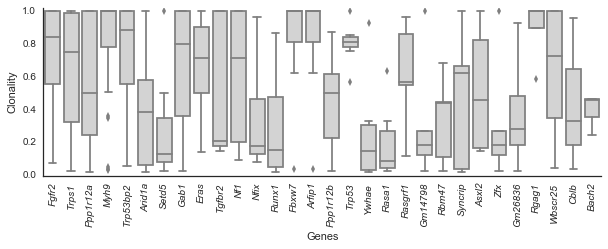

In [6]:
# Order genes by their ranking.
cis_order = list(nb_ins.gene_sample_count(cis_insertions)
                       .sort_values(ascending=False).index)

# Plot clonality of insertions.
fig, ax = plt.subplots(figsize=(10, 3))
nb_ins.plot_gene_clonality_boxplot(
    cis_insertions, order=cis_order, 
    ax=ax, max_per_gene=True)

# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7): 
    fig, ax = plt.subplots(figsize=(8.5, 1.5))
    nb_ins.plot_gene_clonality_boxplot(
        cis_insertions, order=cis_order, 
        max_per_gene=True, ax=ax,
        linewidth=0.5, fliersize=2)

fig.savefig('../reports/supplemental/figures/fig_s6_clonality.pdf',
            bbox_inches='tight')    
plt.close(fig)

## Subtype enrichment

To determine if CIS genes are specifically enriched in any of the previously identified expression subtypes, we test for associations between genes and subtypes using the Fishers Exact test, correcting for multiple testing using Benjamini Hochberg multiple testing correction.

We perform two versions of the test. In the first, we consider the ILC-1 and ILC-2 clusters separately, to determine if any genes are specifically enriched in these subtypes. In the second, we combine the ILC-1 and ILC-2 clusters to a single ILC cluster, to identify genes that are enriched in ILC samples in general.

Additionally, because we filtered tumors based on their morphology to remove cases that were not ILCs but mainly showed Spindle-cell or Squamous morphologies, the corresponding gene expression subtypes may be under-represented in the filtered dataset. Therefore, we apply the described tests to two versions of the dataset: the 'filtered' dataset and a full dataset containing all samples. In the latter, we expect to have more power to find associations than the former.

### ILC samples

First we apply the described test to the filtered dataset, which contains only samples that had an ILC morphology (99 samples).

In [7]:
from IPython.display import display
from nbsupport.enrichment import associations as nb_assoc

# Get subtypes.
nmf_subtypes = pd.read_csv('../data/processed/sb/nmf/subtypes.txt',
                           sep='\t', index_col=0)

# Summarize gene clonality per sample.
sample_mat = nb_ins.clonality_matrix(cis_insertions).T > 0
    
# Test individual clusters.
res_subtype = nb_assoc.test_associations(
    nmf_subtypes[['subtype']], sample_mat,
    alternative='greater', labels=('cluster', 'gene'))
res_subtype = res_subtype.query('p_value_corr < 0.1')

print('Subtypes')
display(res_subtype)

# Test merged clusters.
res_subtype_merged = nb_assoc.test_associations(
    nmf_subtypes[['subtype_merged']], sample_mat,
    alternative='greater', labels=('cluster', 'gene'))
res_subtype_merged = res_subtype_merged.query('p_value_corr < 0.1')

print('Merged subtypes')
display(res_subtype_merged)

Subtypes


,cluster,gene,p_value,p_value_corr
35,subtype_ILC-2,Eras,0.000552,0.033099
113,subtype_Squamous-like,Tgfbr2,0.000062,0.007397


Merged subtypes


,cluster,gene,p_value,p_value_corr
83,subtype_merged_Squamous-like,Tgfbr2,0.000062,0.005548


These results show that we find two associations between subtypes and genes, namely *Eras* with ILC-2 and *Tgfbr2* with the Squamous subtype. The merged test shows that the *Eras* enrichment is specific to ILC-2, as *Eras* is not enriched in the combined ILC subtype.

To visualize these results, we create four horizontal bar graphs (one per subtype), which show the frequency of each CIS gene in each of the subtypes. Significant associations are highlighted in red. 

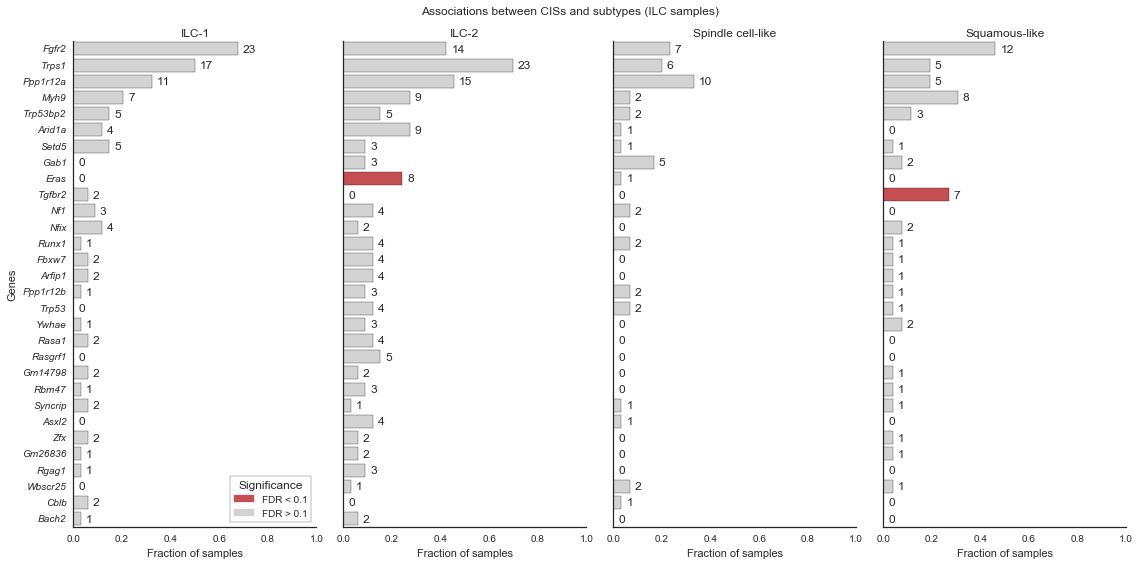

In [8]:
from collections import defaultdict
from nbsupport.expression.subtypes import SUBTYPE_ORDER

# Get associations with subtypes.
subtype_assocs = defaultdict(list, {
    cluster.split('_')[1]: list(grp['gene'])
    for cluster, grp in res_subtype.groupby('cluster')})

res_ilc_mask = res_subtype_merged.cluster.str.endswith('ILC')
ilc_assocs = list(res_subtype_merged.loc[res_ilc_mask]['gene'])

subtype_assocs['ILC-1'] += ilc_assocs
subtype_assocs['ILC-2'] += ilc_assocs

# Plot counts per subtype for all genes.
shared_kws = dict(
    highlight=subtype_assocs,
    highlight_labels=('FDR < 0.1', 'FDR > 0.1'),
    legend_kws=dict(title='Significance'),
    col_order=SUBTYPE_ORDER)

g = nb_ins.plot_subtype_counts(
    cis_insertions, nmf_subtypes['subtype'], 
    order=cis_order, size=8, aspect=0.5, **shared_kws)

g.fig.suptitle('Associations between CISs and subtypes (ILC samples)', fontsize=12)
g.fig.subplots_adjust(top=0.92)

# Draw again for paper with slightly different scaling.
with sns.plotting_context('paper', font_scale=0.7):
    g = nb_ins.plot_subtype_counts(
        cis_insertions, nmf_subtypes['subtype'], size=3.8, order=cis_order,
        aspect=0.45, annotate_kws={'fontsize': 5}, **shared_kws)
    g.fig.suptitle('Associations between CISs and subtypes (ILC samples)', fontsize=7)
    g.fig.subplots_adjust(top=0.9)

g.savefig('../reports/supplemental/figures/fig_s5_subtype_assocs.pdf', bbox_inches='tight')
plt.close(g.fig);

### All samples

Next, we perform the same analysis using insertions from the entire dataset (123 samples).

In [11]:
# Summarize gene clonality per sample.
insertions_all_samples = (pd.read_csv('../data/processed/sb/shear_splink/full/'
                                      'all/insertions.cis.rbm.txt', sep='\t')
                            .pipe(nb_ins.annotate_with_clonality))
sample_mat_all = nb_ins.clonality_matrix(insertions_all_samples).T > 0

# Test individual clusters.
res_subtype_all = nb_assoc.test_associations(
    nmf_subtypes[['subtype']], sample_mat_all,
    alternative='greater', labels=('cluster', 'gene'))
res_subtype_all = res_subtype_all.query('p_value_corr < 0.1')

print('Subtypes')
display(res_subtype_all)

# Test merged clusters.
res_subtype_merged_all = nb_assoc.test_associations(
    nmf_subtypes[['subtype_merged']], sample_mat_all,
    alternative='greater', labels=('cluster', 'gene'))
res_subtype_merged_all = res_subtype_merged_all.query('p_value_corr < 0.1')

print('Merged subtypes')
display(res_subtype_merged_all)

Subtypes


,cluster,gene,p_value,p_value_corr
32,subtype_ILC-2,Arid1a,3.323740e-03,0.082429
36,subtype_ILC-2,Eras,3.212765e-04,0.019919
50,subtype_ILC-2,Rasgrf1,9.711229e-04,0.030105
59,subtype_ILC-2,Trps1,4.898831e-04,0.020249
118,subtype_Squamous-like,Tgfbr2,4.778249e-07,0.000059


Merged subtypes


,cluster,gene,p_value,p_value_corr
28,subtype_merged_ILC,Trps1,3.281936e-04,0.015261
87,subtype_merged_Squamous-like,Tgfbr2,4.778249e-07,0.000044


This shows that we find quite a few additional assoications in this larger dataset. Strikingly, the ILC-2 subtype gains a number of additional genes that are specifically enriched in this subtype (*Arid1a*, *Rasgrf1* and *Trps1*). However, from the combined analysis, we see that *Trps1* is not specifically enriched in ILC-2 but is also enriched in the combined ILC cluster. This suggests that *Trsp1* is generally enriched in tumors belonging to the ILC subtypes.

Finally, we visualize these results using the same approach as before:

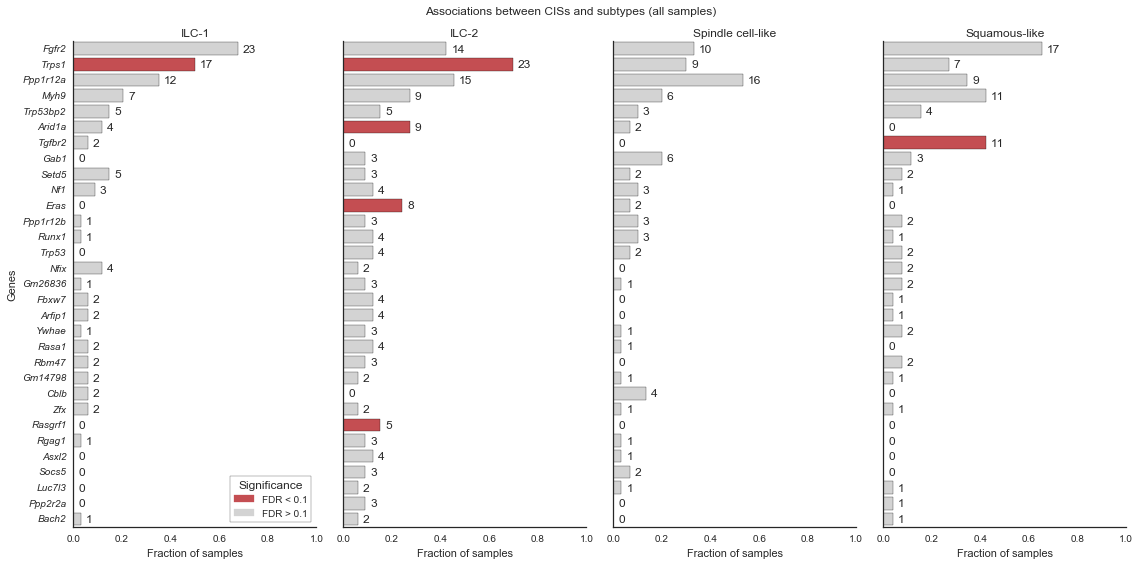

In [12]:
# Get associations with subtypes.
subtype_assocs_all = defaultdict(list, {
    cluster.split('_')[1]: list(grp['gene'])
    for cluster, grp in res_subtype_all.groupby('cluster')})

res_ilc_mask = res_subtype_merged_all.cluster.str.endswith('ILC')
ilc_assocs = list(res_subtype_merged_all.loc[res_ilc_mask]['gene'])

subtype_assocs_all['ILC-1'] += ilc_assocs
subtype_assocs_all['ILC-2'] += ilc_assocs

# Add Trps1 (enriched in combined ILC groups).
if 'ILC-1' not in subtype_assocs_all:
    subtype_assocs_all['ILC-1'] = []

order = list(insertions_all_samples
             .groupby('gene_name')
             ['sample'].nunique()
             .sort_values(ascending=False)
             .index)
         
# Plot counts per subtype for all genes.
shared_kws = dict(
    order=order,
    col_order=SUBTYPE_ORDER,
    highlight=subtype_assocs_all,
    highlight_labels=('FDR < 0.1', 'FDR > 0.1'),
    legend_kws=dict(title='Significance'))

g = nb_ins.plot_subtype_counts(
    insertions_all_samples, nmf_subtypes['subtype'],
    size=8, aspect=0.5, **shared_kws)

g.fig.suptitle('Associations between CISs and subtypes (all samples)', fontsize=12)
g.fig.subplots_adjust(top=0.92)

# Draw again for paper with slightly different scaling.
with sns.plotting_context('paper', font_scale=0.7):
    g = nb_ins.plot_subtype_counts(
        insertions_all_samples, nmf_subtypes['subtype'], size=3.8,
        aspect=0.45, annotate_kws={'fontsize': 5}, **shared_kws)
    g.fig.suptitle('Associations between CISs and subtypes (all samples)', fontsize=7)
    g.fig.subplots_adjust(top=0.9)

g.savefig('../reports/supplemental/figures/fig_s5_subtype_assocs_all_samples.pdf', bbox_inches='tight')
plt.close(g.fig);

## Effects of insertions

### Orientation bias

To determine how the SB insertions affected the expression of the candidate genes, we investigate orientation biases of the SB insertions in each candidate gene. The reasoning behind this analysis is that T2/Onc transposons can only activate gene expression when integrated in the same orientation as the gene, but can inactivate/truncate gene transcripts regardless of their orientation. As a result, we expect genes that are activated by their insertions to have mainly sense insertions, whilst genes that are inactivated would be biased towards antisense insertions (or a mix of the two).

To visualize this bias, we create a scatter plot with the frequency of a gene along the x-axis and the (weighted) fraction of sense insertions along the y-axis. This fraction is essentially the proportion of sense insertions, weighted by the clonality of the corresponding insertions. As a result, insertions with a high clonality are given more weight than weaker insertions.

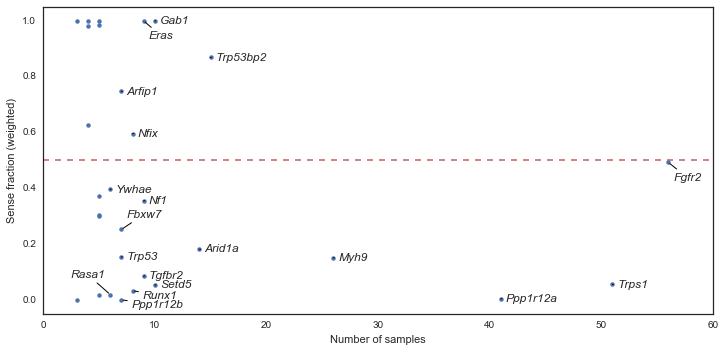

In [13]:
# Plot orientation bias.
label_offsets = {'Eras': (5, -15), 
                 'Fbxw7': (5, 15), 
                 'Fgfr2': (5, -15),
                 'Rasa1': (-40, 20),
                 'Ppp1r12b': (10, -5),
                 'Runx1': (10, -5)}

fig = nb_ins.plot_orientation_bias(
    cis_insertions, min_samples=5.5,
    label_offsets=label_offsets)

# Draw again for paper.
label_offsets = {'Eras': (5, -10), 
                 'Fgfr2': (-10, -10),
                 'Tgfbr2': (5, 2),
                 'Rasa1': (-30, 8),
                 'Ppp1r12b': (-35, 22),
                 'Runx1': (5, -5)}

with sns.plotting_context('paper', font_scale=0.7):
    fig = nb_ins.plot_orientation_bias(
        cis_insertions, min_samples=5.5,
        label_offsets=label_offsets, figsize=(8, 2.5)) 

fig.savefig('../reports/figures/fig_3_bias.pdf', bbox_inches='tight')
plt.close()

This analysis shows that four candidates (*Trp53bp2*, *Gab1*, *Arfip1*, *Eras*) contain mainly sense insertions, indicating that these genes are likely activated by their insertions. In contrast, most candidate genes show no orientation bias or are biased towards antisense insertions (e.g. *Trps1*, *Ppp1r12a*) and are therefore likely inactivated/truncated by their insertions. 

To show two examples of this, we create an additional plot that draws insertions alongside the transcript of their corresponding gene. We use a Python package called **geneviz** to create these plots, which we specifically created for the purpose of drawing genomic data together with gene annotations in a traditional track-based type of plot.

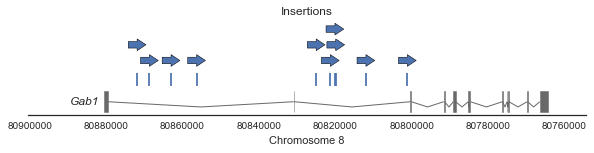

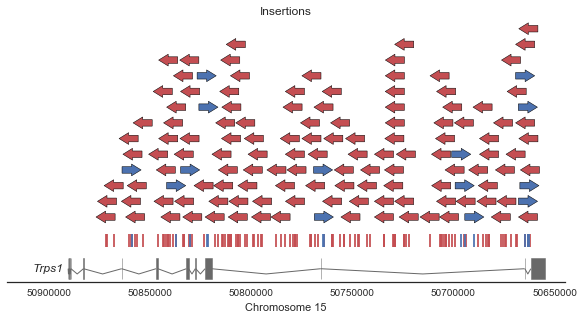

In [14]:
from nbsupport.insertions import plot_insertion_track

# Plot insertion patterns for Gab1/Trps1.
plot_insertion_track(cis_insertions, region=('8', 80764438, 80880519), 
                     gene='Gab1', padding=(20000, 10000), reverse=True, 
                     figsize=(10, None));

plot_insertion_track(cis_insertions, region=('15', 50654752, 50890463), 
                     gene='Trps1', padding=(30000, 10000), reverse=True,
                     figsize=(10, None));

# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig = plot_insertion_track(
        cis_insertions, region=('8', 80764438, 80880519), figsize=(9, 0.8),
        gene='Gab1', padding=(20000, 10000), reverse=True, ins_ratio=1/50);
    fig.savefig('../reports/supplemental/figures/fig_s6_gab1.pdf', bbox_inches='tight')
    plt.close(fig)
    
    fig = plot_insertion_track(
        cis_insertions, region=('15', 50654752, 50890463), figsize=(9, 2),
        gene='Trps1', padding=(30000, 10000), reverse=True, ins_ratio=1/50);
    fig.savefig('../reports/supplemental/figures/fig_s6_trps1.pdf', bbox_inches='tight')
    plt.close(fig)

These plots include three tracks: an insertion track, a (insertion) density track and a gene annotation track. The insertion track indicates the location of each insertion as an arrow, with the direction of the arrow indicating the orientation of the insertion (forward/reverse strand) and the color indicating the orientation relative to the gene (sense/antisense). The density track indicates the precise location of the insertions, effectively providing a better sense for where each insertion exactly is located on the gene transcript. The annotation track shows the structure of the corresponding gene transcript. For this visualization, genes with multiple transcripts have been collapsed into a single transcript.

The above plots clearly illustrate that *Gab1* is mainly affected by sense insertions, as indicated by our orientation bias analysis, and that these insertions mainly occur early in the gene. This indicates that the gene is likely over-expressed as a result of these insertions. For *Trps1* we see mainly antisense insertions, which are scattered throughout the gene. This indicates that *Trps1* is mainly inactivated by its insertions.

### Differential expression (IM-Fusion)

To provide additional evidence that genes are activated or inactivated by their insertions, we use the differential expression test from IM-Fusion [REF] to test for differential expression over the insertion sites in a gene. In this case, we expect genes that are activated by their insertions to show an increase in expression after the insertion sites, whilst genes that are inactivated/truncated are expected to show a decrease in expression.

For thist test, we first load exon expression counts for the samples. These counts were generated from the RNA-seq alignments using featureCounts with a exon-level GTF file that was created using DEXSeq. This pre-processing was performed in a separate Snakemake workflow, due to its computationally intensive nature.

In [15]:
from imfusion.expression.counts import read_exon_counts
from imfusion.expression.test import test_de

name_map = dict(zip(samples['rnaseq_id'], samples['sample']))
exon_counts = (read_exon_counts('../data/processed/sb/rnaseq/exon_counts.txt')
               .rename(columns=name_map))

exon_counts.head()

12SKA095-R3  12SKA136-L2  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                 0            0   
ENSMUSG00000064842 1   3102016 3102125 +                 0            0   
ENSMUSG00000051951 1   3205901 3206522 -                 0            0   
                       3206523 3207317 -                 0            0   
                       3213439 3213608 -                 2            0   

                                               13SKA010-R2  12SKA102-R3  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                 0            0   
ENSMUSG00000064842 1   3102016 3102125 +                 0            0   
ENSMUSG00000051951 1   3205901 3206522 -                 0            1   
                       3206523 3207317 -                 0            0   
                       3213439 3213608 -                 0            0   

                                               13SKA011-L3  11KOU028-L5  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                 0            0   
ENSMUSG00000064842 1   3102016 3102125 +                 0            0   
ENSMUSG00000051951 1   3205901 3206522 -                 0            1   
                       3206523 3207317 -                 0            0   
                       3213439 3213608 -                 0            0   

                                               12SKA022  12SKA079-L3  \
gene_id            chr start   end     strand                          
ENSMUSG00000090025 1   3054233 3054733 +              0            0   
ENSMUSG00000064842 1   3102016 3102125 +              0            0   
ENSMUSG00000051951 1   3205901 3206522 -              1            1   
                       3206523 3207317 -              0            1   
                       3213439 3213608 -              0            0   

                                               12SKA084-L3  \
gene_id            chr start   end     strand                
ENSMUSG00000090025 1   3054233 3054733 +                 0   
ENSMUSG00000064842 1   3102016 3102125 +                 0   
ENSMUSG00000051951 1   3205901 3206522 -                 0   
                       3206523 3207317 -                 0   
                       3213439 3213608 -                 0   

                                               2800_12_12SKA060-R3  \
gene_id            chr start   end     strand                        
ENSMUSG00000090025 1   3054233 3054733 +                         0   
ENSMUSG00000064842 1   3102016 3102125 +                         0   
ENSMUSG00000051951 1   3205901 3206522 -                         0   
                       3206523 3207317 -                         0   
                       3213439 3213608 -                         0   

                                                      ...           \
gene_id            chr start   end     strand         ...            
ENSMUSG00000090025 1   3054233 3054733 +              ...            
ENSMUSG00000064842 1   3102016 3102125 +              ...            
ENSMUSG00000051951 1   3205901 3206522 -              ...            
                       3206523 3207317 -              ...            
                       3213439 3213608 -              ...            

                                               2800_79_13SKA014-L2-neck  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                              0   
ENSMUSG00000064842 1   3102016 3102125 +                              0   
ENSMUSG00000051951 1   3205901 3206522 -                              0   
                       3206523 3207317 -                              1   
                       3213439 3213608 -                              0   

                     

Next, we perform the actual tests and plot the results.

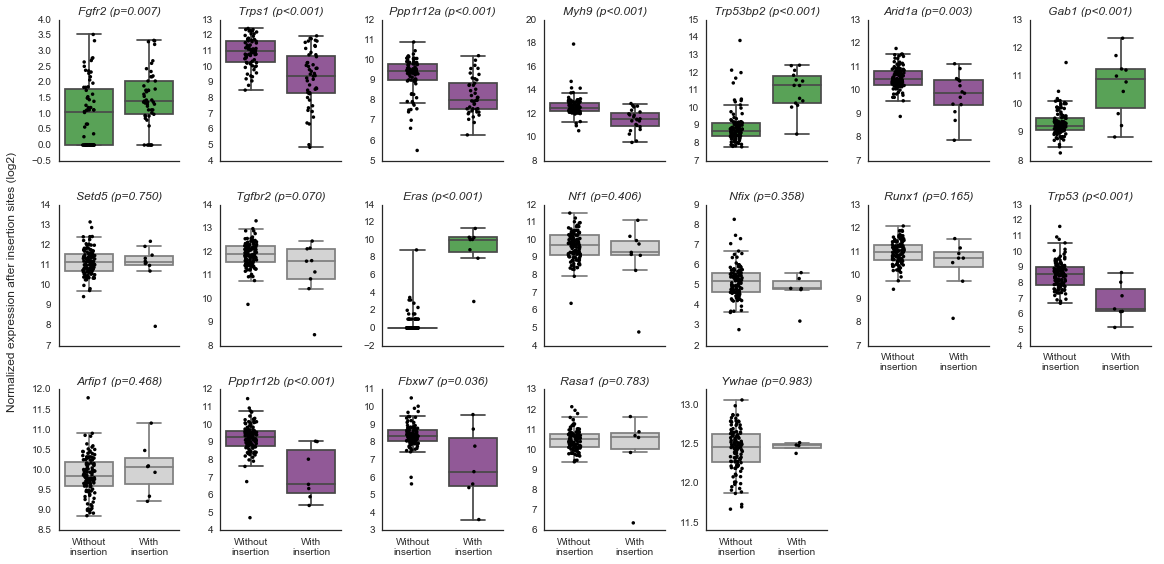

In [16]:
gene_id_map = dict(zip(cis_insertions['gene_name'], 
                       cis_insertions['gene_id']))

ranked_genes = (
    nb_ins.gene_sample_count(cis_insertions)
          .reset_index()
          .query('n_samples > 5')
          .sort_values('n_samples', ascending=False)
          .reset_index()
          .assign(gene_id=lambda df: df['gene_name'].map(gene_id_map)))


cis_insertions_imf = (
    cis_insertions.rename(columns={'chromosome': 'seqname'})
                  .assign(support_junction=lambda df: df['support'],
                          support_spanning=0))

nb_ins.plot_de_multiple(cis_insertions_imf, exon_counts, 
                        figsize=(16, 8), ncols=7,
                        gene_ids=ranked_genes['gene_id'],
                        gene_names=ranked_genes['gene_name'])

with sns.plotting_context('paper', font_scale=0.6):
    fig = nb_ins.plot_de_multiple(
        cis_insertions_imf, exon_counts, 
        figsize=(7, 3.2), ncols=7,
        gene_ids=ranked_genes['gene_id'],
        gene_names=ranked_genes['gene_name'],
        box_kws={'linewidth': 0.5},
        strip_kws={'size': 1.5})
    
    fig.suptitle('Differential expression over insertion sites',
                 fontsize=7, y=1.04)
    fig.savefig('../reports/supplemental/figures/fig_s6_diff_expr.pdf', bbox_inches='tight')
    
    plt.close(fig)

These results show that most of genes that we expected to be inactivated/truncated indeed show a decrease in expression after their insertions. Simimarly, genes dominanted by sense insertions (such as *Gab1*) are indeed found to be over-expressed.

## Pathway analysis (KEGG)

To determine which processes or pathways are affected by the insertions, we performed a KEGG pathway enrichment analysis using all CIS genes. This analysis essentially uses a Fishers Exact test to test for associations between the CIS genes and KEGG pathways, correcting for multiple testing using Benjamini Hochberg multiple testing correction.

Note that the KEGG pathways are obtained from the KEGG REST API, which may be subjective to change over time.

In [17]:
from nbsupport.enrichment import genesets as nb_genes

# Fetch gene sets and translate to symbol.
kegg_sets = nb_genes.kegg.get_gene_sets('mmu')
kegg_sets = nb_genes.map_sets(
    kegg_sets, from_type='entrez', to_type='symbol',
    from_organism='mmusculus', mapper='ensembl')

# Test for enrichment.
result = nb_genes.test_sets(
    set(cis_insertions['gene_name']), kegg_sets,
    corr_method='fdr_bh', include_overlap=True)

result_sign = (
    result.query('p_value_corr < 0.1')
          .sort_values(['p_value', 'p_value_corr']))

result_sign

,gene_set,p_value,p_value_corr,overlap
42,MAPK signaling pathway,0.000005,0.001563,"Fgfr2, Nf1, Rasa1, Rasgrf1, Tgfbr2, Trp53"
39,Chronic myeloid leukemia,0.000011,0.001628,"Cblb, Runx1, Tgfbr2, Trp53"
63,Proteoglycans in cancer,0.000032,0.003260,"Cblb, Gab1, Ppp1r12a, Ppp1r12b, Trp53"
176,Ras signaling pathway,0.000057,0.004306,"Fgfr2, Gab1, Nf1, Rasa1, Rasgrf1"
278,EGFR tyrosine kinase inhibitor resistance,0.000498,0.030082,"Fgfr2, Gab1, Nf1"
296,Regulation of actin cytoskeleton,0.000724,0.031696,"Fgfr2, Myh9, Ppp1r12a, Ppp1r12b"
159,Pathways in cancer,0.000735,0.031696,"Cblb, Fgfr2, Runx1, Tgfbr2, Trp53"
7,Neurotrophin signaling pathway,0.001741,0.065726,"Gab1, Trp53, Ywhae"


The results show a number of pathways to be enriched. Interestingly, the PI3K/AKT pathway (which is frequently abberated in human ILCs) is not significantly enriched in our list of genes:

In [18]:
result.ix[result['gene_set'].str.contains('PI3K')]

,gene_set,p_value,p_value_corr,overlap
95,PI3K-Akt signaling pathway,0.027169,0.390716,"Fgfr2, Trp53, Ywhae"


In [19]:
! mkdir -p ../reports/tables/
(result_sign.rename(columns={'gene_set': 'Gene set',
                             'p_value': 'p-value',
                             'p_value_corr': 'FDR',
                             'overlap': 'Overlapping genes'})
            .to_excel('../reports/tables/table_1_kegg.xlsx', index=False, float_format='%3.2e'))

## Mutual exclusivity analysis

To identify further evidence that insertions may be targeting a common biological process or pathway, we use DISCOVER to test for co-occurrence and mutual exclusivity associations between candidate genes. To identify groups of mutually exclusive genes, we first use a pairwise-test to identify interesting pairwise associations and then combine these results into larger groups.

In [20]:
try:
    import discover
except ImportError:
    ! cd ../tmp && git clone https://github.com/NKI-CCB/DISCOVER.git
    ! pip install ../tmp/DISCOVER/python
    ! rm -rf ../tmp/DISCOVER
    
# Convert to boolean matrix.
ins_mat = pd.pivot_table(
    cis_insertions, index='gene_name', columns='sample',
    values='support', aggfunc='max', fill_value=0)
ins_mat = (ins_mat > 0).astype(int)

# Test pairwise mutex.
events = discover.DiscoverMatrix(ins_mat)
result_mutex = discover.pairwise_discover_test(events)
result_mutex.significant_pairs(q_threshold=0.25).sort_values('pvalue')

/home/NFS/users/j.d.ruiter/.anaconda3/envs/sb-screen/lib/python3.5/site-packages/discover/pairwise.py:109: RuntimeWarning: invalid value encountered in less
  i, j = numpy.where(self.pi0 * numpy.asarray(self.qvalues) < q_threshold)


,gene1,gene2,pvalue,qvalue
5,Ppp1r12a,Trp53bp2,0.009052,0.181943
4,Ppp1r12a,Ppp1r12b,0.018409,0.181943
3,Myh9,Trp53bp2,0.022027,0.181943
2,Myh9,Ppp1r12a,0.026523,0.181943
0,Fgfr2,Rasgrf1,0.026745,0.181943
1,Myh9,Nf1,0.030593,0.184622


From these pairwise associations, we see that *Ppp1r12a/b*, *Myh9* and *Trp53bp2* may be part of a larger group of mutually exclusive genes. To test this, we calculate a p-value for this group of four genes:

In [21]:
# Test group-wise for this larger group.
genes = ["Myh9", "Trp53bp2", "Ppp1r12a", "Ppp1r12b"]
discover.groupwise_discover_test(events[genes])

0.00017451543696258705

This shows that this group does indeed show significant mutual exclusivity, suggesting that these genes may be targeting a common biological pathway. This is in concordance with the KEGG analysis, which shows that three of these genes are involved in the 'Regulation of actin cytoskeleton' pathway.

To visualize this mutual exclusivity, we use the same plot as we previously used to visualize the entire candidate list:

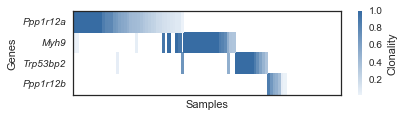

In [22]:
# Plot.
mutex_genes = ['Ppp1r12a', 'Myh9', 'Trp53bp2', 'Ppp1r12b']

fig, ax = plt.subplots(figsize=(6, 1.5))
nb_ins.plot_insertion_matrix(cis_insertions, genes=mutex_genes, ax=ax);

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(3.8, 0.75))
    nb_ins.plot_insertion_matrix(cis_insertions, genes=mutex_genes, ax=ax)

fig.savefig('../reports/figures/fig_3_mutex.pdf', bbox_inches='tight')
plt.close(fig)